# JAX Tutorial
Following [AI Epiphany JAX Tutorial 1](https://www.youtube.com/watch?v=SstuvS-tVc0&t=323s)

In [1]:
import jax.numpy as jnp
import numpy as np
# Transform functions
from jax import grad, jit, vmap, pmap
# JAX low level API
import jax
from jax import lax
from jax import make_jaxpr
from jax import device_put
import matplotlib.pyplot as plt
# Trying out symbolic version
import sympy as sp
import sympy2jax

In [31]:
sp.init_printing(use_latex=True)

JAX syntax is similar to NumPy

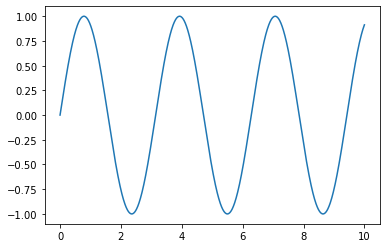

In [2]:
x_np = np.linspace(0, 10, 1000)
y_np = 2*np.sin(x_np)*np.cos(x_np)
_ = plt.plot(x_np, y_np)

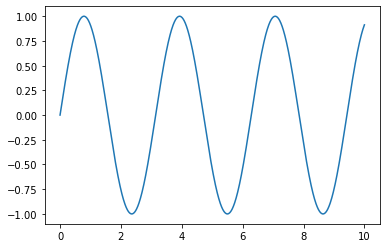

In [3]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2*jnp.sin(x_jnp)*jnp.cos(x_jnp)
_ = plt.plot(x_jnp, y_jnp)

Functional programming - need to get familiar with this
JAX arrays as immutable

In [4]:
size = 10
index = 0
value = 23
x = jnp.arange(size)
print(x)
try:
    x[index] = value
except TypeError as ex:
    print(ex)
print(x)

y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
'<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


Handling random numbers

In [5]:
seed = 0
key = jax.random.PRNGKey(seed)

x = jax.random.normal(key, (10, )) # Need to explicitly pass in key
print(type(x), x)

<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


JAX is device agnostic (DeviceArray) - don't need to do the PyTorch to_device etc

In [6]:
size = 3000
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

In [7]:
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # Would be fast on GPU

1.37 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit np.dot(x_np, x_np.T)  # Would be slower on CPU

536 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # With transfer overhead would be faster than CPU but slower than GPU

1.3 s ± 187 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# JAX Transform Functions

In [10]:
# Helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

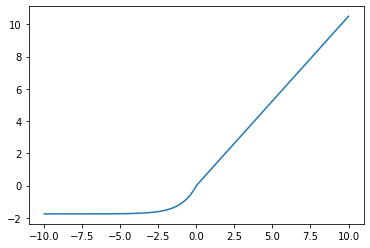

In [11]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)
visualize_fn(selu)

In [12]:
data = jax.random.normal(key, (1000000, ))
%timeit selu(data).block_until_ready()
%timeit selu_jit(data).block_until_ready()

6.75 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.31 ms ± 839 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


grad() 101
Differentiation can be
* manual
* symbolic
* numeric
* automatic

In [13]:
def sum_logistic(x):
    return jnp.sum(1.0/(1.0 + jnp.exp(-x)))

In [14]:
x = jnp.arange(3.)
loss = sum_logistic
grad_loss = grad(loss)
print(grad_loss(x))

[0.25       0.19661197 0.10499357]


## Digression - SymPy
Look at how to represent the loss function and gradient in SymPy.  There are a few possible ways to do this

* explicit summation over IndexedBase symbols
* Array or Matrix symbols with tensorcontraction
* ...

In [15]:
def sp_sum_logistic(x, n):
    i = sp.symbols('i', cls=sp.Idx)
    return sp.Sum(1/(1 + sp.exp(-x[i])), (i, 0, n-1))

x_s = sp.IndexedBase('x')

In [16]:
sp_sum_logistic(x_s, 3)

Sum(1/(1 + exp(-x[i])), (i, 0, 2))

In [17]:
sp_sum_logistic(x_s, 3).doit()

1/(1 + exp(-x[2])) + 1/(1 + exp(-x[1])) + 1/(1 + exp(-x[0]))

In [18]:
x_s_els = [x_s[i] for i in range(3)]

In [19]:
sp_grad_loss = [sp_sum_logistic(x_s, 3).diff(x).doit() for x in x_s_els]
sp_grad_loss

[exp(-x[0])/(1 + exp(-x[0]))**2,
 exp(-x[1])/(1 + exp(-x[1]))**2,
 exp(-x[2])/(1 + exp(-x[2]))**2]

In [20]:
[g.subs(dict(zip(x_s_els, x))) for g in sp_grad_loss]

[1/4, 0.196611933241482, 0.104993585403507]

In [21]:
np_sum_logistic = sp.lambdify(x_s,sp_sum_logistic(x_s, 3), modules='numpy')

In [22]:
np_sum_logistic(x)

2.1118556689996186

In [23]:
sum_logistic(x)

DeviceArray(2.1118555, dtype=float32)

Look at using Array or Matrix instead

In [38]:
A = sp.Matrix(sp.symarray('A', (3, )))
B = sp.Matrix(sp.symarray('B', (4, )))
A, B

⎛      ⎡B₀⎤⎞
⎜⎡A₀⎤  ⎢  ⎥⎟
⎜⎢  ⎥  ⎢B₁⎥⎟
⎜⎢A₁⎥, ⎢  ⎥⎟
⎜⎢  ⎥  ⎢B₂⎥⎟
⎜⎣A₂⎦  ⎢  ⎥⎟
⎝      ⎣B₃⎦⎠

In [44]:
sp.tensorcontraction(A, (0, ))

[A₀ + A₁ + A₂]

In [25]:
A @ B.T

Matrix([
[A_0*B_0, A_0*B_1, A_0*B_2, A_0*B_3],
[A_1*B_0, A_1*B_1, A_1*B_2, A_1*B_3],
[A_2*B_0, A_2*B_1, A_2*B_2, A_2*B_3]])

In [50]:
sp.tensorcontraction(A @ A.T, (0, ))

⎡  2                            2                            2⎤
⎣A₀  + A₀⋅A₁ + A₀⋅A₂  A₀⋅A₁ + A₁  + A₁⋅A₂  A₀⋅A₂ + A₁⋅A₂ + A₂ ⎦

In [26]:
(A @ B.T).diff(B[0])

Matrix([
[A_0, 0, 0, 0],
[A_1, 0, 0, 0],
[A_2, 0, 0, 0]])

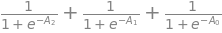

In [54]:
A.applyfunc(lambda x: 1/(1+sp.exp(-x))).dot(sp.ones(*A.shape))

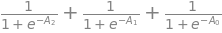

In [53]:
sp.tensorcontraction(A.applyfunc(lambda x: 1/(1+sp.exp(-x))), (0,))[0]


In [57]:
# Derive by array is what we want for gradient operations
sp.derive_by_array(sp.tensorcontraction(A.applyfunc(lambda x: 1/(1+sp.exp(-x))), (0,))[0], A)

⎡     -A₀   ⎤
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -A₀⎞ ⎥
⎢⎝1 + ℯ   ⎠ ⎥
⎢           ⎥
⎢     -A₁   ⎥
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -A₁⎞ ⎥
⎢⎝1 + ℯ   ⎠ ⎥
⎢           ⎥
⎢     -A₂   ⎥
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -A₂⎞ ⎥
⎣⎝1 + ℯ   ⎠ ⎦

In [77]:
# Compare with using MatrixSymbol and as_explicit to show elements
# Nicer but gives 2 element index here
A_s = sp.MatrixSymbol('A', 3, 1)
A_s.as_explicit()

⎡A₀₀⎤
⎢   ⎥
⎢A₁₀⎥
⎢   ⎥
⎣A₂₀⎦

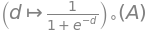

In [78]:
fA_s = A_s.applyfunc(lambda x: 1/(1+sp.exp(-x)))
fA_s

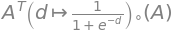

In [79]:
# Play around with matrix symbols
(A_s.T @ fA_s )

In [80]:
(A_s.T @ fA_s ).as_explicit()

⎡   A₂₀         A₁₀         A₀₀   ⎤
⎢───────── + ───────── + ─────────⎥
⎢     -A₂₀        -A₁₀        -A₀₀⎥
⎣1 + ℯ       1 + ℯ       1 + ℯ    ⎦

In [81]:
sp.derive_by_array(sp.tensorcontraction(fA_s.doit().as_explicit(), (0, ))[0], A_s.as_explicit())

⎡    -A₀₀    ⎤
⎢   ℯ        ⎥
⎢────────────⎥
⎢           2⎥
⎢⎛     -A₀₀⎞ ⎥
⎢⎝1 + ℯ    ⎠ ⎥
⎢            ⎥
⎢    -A₁₀    ⎥
⎢   ℯ        ⎥
⎢────────────⎥
⎢           2⎥
⎢⎛     -A₁₀⎞ ⎥
⎢⎝1 + ℯ    ⎠ ⎥
⎢            ⎥
⎢    -A₂₀    ⎥
⎢   ℯ        ⎥
⎢────────────⎥
⎢           2⎥
⎢⎛     -A₂₀⎞ ⎥
⎣⎝1 + ℯ    ⎠ ⎦

In [28]:
X = sp.Matrix(sp.symarray('x', 3))
sp_loss = X.applyfunc(lambda x: 1/(1+sp.exp(-x))).dot(sp.ones(*X.shape))
sp_grad = X.applyfunc(lambda x: sp_loss.diff(x))
sp_grad

Matrix([
[exp(-x_0)/(1 + exp(-x_0))**2],
[exp(-x_1)/(1 + exp(-x_1))**2],
[exp(-x_2)/(1 + exp(-x_2))**2]])

In [55]:
sp.derive_by_array(sp_loss, X)

⎡     -x₀   ⎤
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -x₀⎞ ⎥
⎢⎝1 + ℯ   ⎠ ⎥
⎢           ⎥
⎢     -x₁   ⎥
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -x₁⎞ ⎥
⎢⎝1 + ℯ   ⎠ ⎥
⎢           ⎥
⎢     -x₂   ⎥
⎢    ℯ      ⎥
⎢───────────⎥
⎢          2⎥
⎢⎛     -x₂⎞ ⎥
⎣⎝1 + ℯ   ⎠ ⎦

In [56]:
sp.derive_by_array(sp_loss, X).subs({X[i]: i for i in range(3)})

⎡   1/4    ⎤
⎢          ⎥
⎢    -1    ⎥
⎢   ℯ      ⎥
⎢──────────⎥
⎢         2⎥
⎢⎛ -1    ⎞ ⎥
⎢⎝ℯ   + 1⎠ ⎥
⎢          ⎥
⎢    -2    ⎥
⎢   ℯ      ⎥
⎢──────────⎥
⎢         2⎥
⎢⎛ -2    ⎞ ⎥
⎣⎝ℯ   + 1⎠ ⎦

In [82]:
f = lambda x, y: x**2 + y**2

In [83]:
from jax import jacfwd, jacrev

In [97]:
x, y = sp.symbols('x y', real=True)
f(x, y)

In [98]:
sp.derive_by_array(f(x,y), [x, y])

[2⋅x  2⋅y]

In [99]:
sp.derive_by_array(sp.derive_by_array(f(x,y), [x, y]), [x, y])

⎡2  0⎤
⎢    ⎥
⎣0  2⎦

In [100]:
F = sp.Matrix([f(x,y)])
F

⎡ 2    2⎤
⎣x  + y ⎦

In [101]:
F.jacobian([x, y])

[2⋅x  2⋅y]

In [102]:
sp.hessian(f(x,y), [x, y])

⎡2  0⎤
⎢    ⎥
⎣0  2⎦

In [103]:
jacrev(f, argnums=(0, 1))(1., 1.)

(DeviceArray(2., dtype=float32, weak_type=True),
 DeviceArray(2., dtype=float32, weak_type=True))

In [104]:
sp.Abs(x).diff()

vmap

In [116]:
W = jax.random.normal(key, (150, 100))
batched_x = jax.random.normal(key, (10, 100))
def apply_mat(W, x):
    return jnp.dot(W, x)

In [117]:
apply_mat(W, batched_x[0,:]).shape

In [118]:
# Fails
try:
    apply_mat(W, batched_x)
except TypeError as ex:
    print(ex)

Incompatible shapes for dot: got (150, 100) and (10, 100).


In [119]:
# Need to specify that first argument (W) doesn't have any batched, second argument (batched_x) uses axis 0 for batches
vmap(apply_mat, in_axes=(None, 0))(W, batched_x).shape

In [126]:
from functools import partial

@partial(jit, static_argnums=(1,))  # Tells jit to ignore second argument
def f(x, neg):
    print(x)
    return -x if neg else x

In [127]:
print(f(1, True))
print(f(2, True)) # Uses cached
print(f(3, False)) # Re-JITs
print(f(4, False)) # Uses cached
print(f(5, True)) # Uses cached

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
3
4
-5


In [154]:
W_0 = sp.MatrixSymbol('W__0', 4, 2)
W_0

In [155]:
W_0.as_explicit()

⎡W⁰₀₀  W⁰₀₁⎤
⎢          ⎥
⎢W⁰₁₀  W⁰₁₁⎥
⎢          ⎥
⎢W⁰₂₀  W⁰₂₁⎥
⎢          ⎥
⎣W⁰₃₀  W⁰₃₁⎦

In [164]:
b_0 = sp.MatrixSymbol('b__0', 4, 1)

In [165]:
x = sp.MatrixSymbol('x', 2, 1)
x

In [166]:
sp.Matrix.vstack(x.as_explicit(),sp.eye(1))

⎡x₀₀⎤
⎢   ⎥
⎢x₁₀⎥
⎢   ⎥
⎣ 1 ⎦

In [167]:
(W_0 @ x + b_0).applyfunc(sp.tanh) # .as_explicit().subs({x.as_explicit()[-1, 0]: 1})

In [168]:
(W_0 @ x + b_0).applyfunc(sp.tanh).as_explicit()

⎡tanh(W⁰₀₀⋅x₀₀ + W⁰₀₁⋅x₁₀ + b⁰₀₀)⎤
⎢                                ⎥
⎢tanh(W⁰₁₀⋅x₀₀ + W⁰₁₁⋅x₁₀ + b⁰₁₀)⎥
⎢                                ⎥
⎢tanh(W⁰₂₀⋅x₀₀ + W⁰₂₁⋅x₁₀ + b⁰₂₀)⎥
⎢                                ⎥
⎣tanh(W⁰₃₀⋅x₀₀ + W⁰₃₁⋅x₁₀ + b⁰₃₀)⎦

In [182]:
((W_0 @ x + b_0).applyfunc(sp.tanh).as_explicit()).jacobian( W_0.as_explicit().reshape(len(W_0.as_explicit()), 1))

⎡⎛        2                            ⎞      ⎛        2                      
⎢⎝1 - tanh (W⁰₀₀⋅x₀₀ + W⁰₀₁⋅x₁₀ + b⁰₀₀)⎠⋅x₀₀  ⎝1 - tanh (W⁰₀₀⋅x₀₀ + W⁰₀₁⋅x₁₀ +
⎢                                                                             
⎢                                                                             
⎢                     0                                            0          
⎢                                                                             
⎢                                                                             
⎢                     0                                            0          
⎢                                                                             
⎢                                                                             
⎣                     0                                            0          

      ⎞                                                                       
 b⁰₀₀)⎠⋅x₁₀                       0                